In [2]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from model_transformers2 import FeaturesInteractions,SkewTransformer,ZeroThreshold
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,QuantileTransformer

import joblib
# sklearn classes
from stacking_models import StackingAveragedModels,AveragingModels

#from mlxtend.regressor import StackingCVRegressor

In [3]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [4]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)     

# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

# Drop outliers
train = train.drop(train[(train['van_der_waals_change']>3)].index)
train = train.drop(train[(train['dg_change'].abs()>8)].index)

y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

In [5]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Modelling

#### Crossvalidation strategy

In [6]:
def cv_results(cv_object):
    
    # scores
    rmse_train_cv = np.sqrt(-cv_object["train_neg_mean_squared_error"])
    rmse_test_cv = np.sqrt(-cv_object["test_neg_mean_squared_error"])
    r2_train_cv = cv_object["train_r2"]
    r2_test_cv = cv_object["test_r2"]
    
    print("RMSE train CV: {:.4f} ({:.4f})".format(rmse_train_cv.mean(),rmse_train_cv.std()))
    print("RMSE test CV: {:.4f} ({:.4f})".format(rmse_test_cv.mean(),rmse_test_cv.std()))
    print('DIFF RMSE {}\n'.format(rmse_test_cv.mean()-rmse_train_cv.mean()))

    print("r2 train CV: {:.4f} ({:.4f})".format(r2_train_cv.mean(),r2_train_cv.std()))
    print("r2 test CV: {:.4f} ({:.4f})".format(r2_test_cv.mean(),r2_test_cv.std()))
    print('DIFF RMSE {}\n'.format(r2_test_cv.mean()-r2_train_cv.mean()))
    
def test_results(fitted_estimator,Xtest,Ytest):
    y_test_pred = fitted_estimator.predict(Xtest)
    #y_train_pred = fitted_estimator.predict(Xtrain)
    
    print("RMSE test: {}".format(np.round(np.sqrt(mean_squared_error(Ytest, y_test_pred)), 2)))

    print('r2 test',r2_score(Ytest,y_test_pred))
    #print('r2 train',r2_score(Ytrain,y_train_pred))
    
    print("Pearson corr test {:f}".format(np.corrcoef(y_test_pred,Ytest.ravel())[0][1]))
    

In [7]:
#Validation function
n_folds = 10

def evaluating(model,Xtrain,Ytarget):
    #kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain)
    rkf = RepeatedKFold(n_splits=10,n_repeats=5,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = rkf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

def evaluating2(model,Xtrain,Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

In [8]:
# preprocess pipeline steps
#steps pipeline
interactions = FeaturesInteractions(features1=range(15),feature2=20)
variance = VarianceThreshold(threshold=0.)
skewness = SkewTransformer(threshold=0.5)
zeroth = ZeroThreshold(threshold=90.)

#### algorithms

In [9]:
#lasso model
lasso = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=True,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=0.5,degree=2,epsilon=0.5,gamma=0.4,kernel='poly'))

svrRBF = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=2.5,epsilon=0.5,gamma=2,kernel='rbf'))

gbt = make_pipeline(interactions,variance,skewness,zeroth,
                    GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7))

xgbr = make_pipeline(interactions,variance,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.6, gamma=0,
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=100,
                             subsample=0.9,random_state =7, nthread=-1,objective='reg:squarederror'))


In [24]:
XGBRegressor?

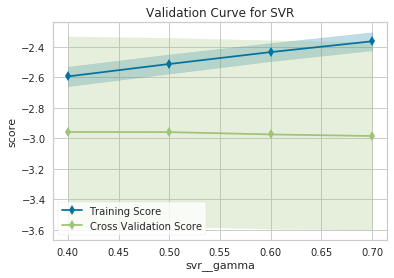

0


In [30]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
#2)
#3) Crear pipeline

viz = ValidationCurve(
    svrP, njobs=-1,param_name="svr__gamma",
    param_range=[0.4,0.5,0.6,0.7], cv=10, scoring="neg_mean_squared_error",n_jobs=-1)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train.values, y_train.values)
viz.poof()
print(viz.test_scores_mean_.argmax())

In [77]:
np.sqrt(-viz.test_scores_mean_)

array([1.58978938, 1.58838006, 1.5870186 , 1.58659171, 1.5865904 ])

#### Base model scores

In [12]:
print('Lasso Model Evaluation')
lassocv = evaluating(lasso,X_train.values,y_train.values)
cv_results(lassocv)

lasso_model = lasso.fit(X_train.values,y_train.values)
test_results(lasso_model,X_test.values,y_test.values)


Lasso Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:    3.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


RMSE train CV: 1.6817 (0.0227)
RMSE test CV: 1.7208 (0.2105)
DIFF RMSE 0.03910935431635032

r2 train CV: 0.1998 (0.0099)
r2 test CV: 0.1449 (0.0859)
DIFF RMSE -0.05492022758381743

RMSE test: 1.72
r2 test 0.25461314167727567
Pearson corr test 0.532055


Text(0, 0.5, 'Residuos')

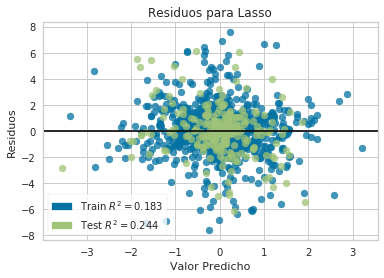

In [33]:
visualizer = ResidualsPlot(lasso_model,title='Residuos para Lasso',hist=False)

visualizer.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

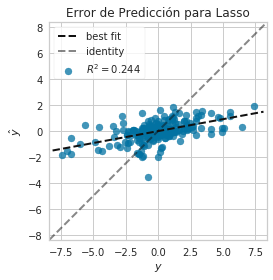

In [34]:
perror = PredictionError(lasso_model, title='Error de Predicción para Lasso')

perror.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()

In [35]:
print('XGBRegressor Model Evaluation')
xgbrcv = evaluating(xgbr,X_train.values,y_train.values)
cv_results(xgbrcv)

xgbr_model = xgbr.fit(X_train.values,y_train.values)
test_results(xgbr_model,X_test.values,y_test.values)


XGBRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:   13.5s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.2s finished


RMSE train CV: 0.1404 (0.0028)
RMSE test CV: 1.6016 (0.1874)
DIFF RMSE 1.461165638706278

r2 train CV: 0.9944 (0.0002)
r2 test CV: 0.2547 (0.1051)
DIFF RMSE -0.7396732158715417

[15:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE test: 1.62
r2 test 0.3353040324149086
Pearson corr test 0.579952


In [36]:
print('SVR polynomial Model Evaluation')
svrPcv = evaluating(svrP,X_train.values,y_train.values)
cv_results(svrPcv)

svrP_model = xgbr.fit(X_train.values,y_train.values)
test_results(svrP_model,X_test.values,y_test.values)

SVR polynomial Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


RMSE train CV: 1.6167 (0.0243)
RMSE test CV: 1.7176 (0.2167)
DIFF RMSE 0.10089119621197828

r2 train CV: 0.2604 (0.0109)
r2 test CV: 0.1486 (0.0884)
DIFF RMSE -0.11179403804026566

[15:34:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE test: 1.62
r2 test 0.3353040324149086
Pearson corr test 0.579952


In [37]:
print('SVR rbf Model Evaluation')
svrRBFcv = evaluating(svrRBF,X_train.values,y_train.values)
cv_results(svrRBFcv)

svrRBF_model = svrRBF.fit(X_train.values,y_train.values)
test_results(svrRBF_model,X_test.values,y_test.values)

SVR rbf Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:    0.5s remaining:    0.7s


RMSE train CV: 1.1164 (0.0211)
RMSE test CV: 1.6475 (0.1976)
DIFF RMSE 0.5310741848547258

r2 train CV: 0.6473 (0.0086)
r2 test CV: 0.2155 (0.0771)
DIFF RMSE -0.4317680870205839

RMSE test: 1.79
r2 test 0.19377667554750988
Pearson corr test 0.440899


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


In [38]:
print('GradientBoostingRegressor Model Evaluation')
gbtcv = evaluating(gbt,X_train.values,y_train.values)
cv_results(gbtcv)

gbt_model = gbt.fit(X_train.values,y_train.values)
test_results(gbt_model,X_test.values,y_test.values)

GradientBoostingRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:   11.7s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.6s finished


RMSE train CV: 0.7091 (0.0201)
RMSE test CV: 1.6070 (0.2016)
DIFF RMSE 0.8979209096661217

r2 train CV: 0.8576 (0.0075)
r2 test CV: 0.2529 (0.0904)
DIFF RMSE -0.6047571088238628

RMSE test: 1.65
r2 test 0.31772960830759545
Pearson corr test 0.567488


In [51]:
print('Averaged Models Evaluation')
averaged_models = AveragingModels(models = (gbt, svrP,lasso))

averaged_models_cv = evaluating(averaged_models,X_train.values,y_train.values)
cv_results(averaged_models_cv)

averaged_models_model = averaged_models.fit(X_train.values,y_train.values)
test_results(averaged_models_model,X_test.values,y_test.values)

Averaged Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:   15.4s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.5s finished


RMSE train CV: 1.2819 (0.0177)
RMSE test CV: 1.6440 (0.2097)
DIFF RMSE 0.3620816725232332

r2 train CV: 0.5350 (0.0071)
r2 test CV: 0.2200 (0.0832)
DIFF RMSE -0.3150140140339657

RMSE test: 1.65
r2 test 0.3118323749569649
Pearson corr test 0.596525


In [55]:
final_avg = averaged_models.fit(full_data.values,y_full.values)
from sklearn.externals import joblib

# save final model

joblib.dump(final_avg, 'avg_models_FINAL.3m.pkl')

['avg_models_FINAL.3m.pkl']

### stacking modells

In [62]:
lassoMeta = make_pipeline(MinMaxScaler(), Lasso(alpha =0.001, random_state=1,normalize=True,fit_intercept=True))
svrPMeta = make_pipeline(make_pipeline(MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly')))

xgbMeta = make_pipeline(make_pipeline(XGBRegressor(colsample_bytree=0.6, gamma=0, 
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=200,
                             subsample=0.9,random_state =7, nthread = -1)))

gbtMeta = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7)

In [63]:
stacked_averaged_models = StackingAveragedModels(base_models = (gbt, svrRBF,lasso),
                                                 meta_model = svrPMeta)

In [64]:
print('Averaged Stacked Models Evaluation')

stacked_averaged_models_cv = evaluating(stacked_averaged_models,X_train.values,y_train.values)
cv_results(stacked_averaged_models_cv)

stacked_averaged_models_model = stacked_averaged_models.fit(X_train.values,y_train.values)
test_results(stacked_averaged_models_model,X_test.values,y_test.values)

Averaged Stacked Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  50 | elapsed:   58.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


RMSE train CV: 1.0998 (0.0354)
RMSE test CV: 1.6193 (0.1994)
DIFF RMSE 0.5194845151768708

r2 train CV: 0.6575 (0.0198)
r2 test CV: 0.2439 (0.0640)
DIFF RMSE -0.41360155782478203

RMSE test: 1.66
r2 test 0.30596059810078313
Pearson corr test 0.590974


In [ ]:
RMSE train CV: 1.1377 (0.0333)
RMSE test CV: 1.6236 (0.1998)
DIFF RMSE 0.4858723883199876

r2 train CV: 0.6336 (0.0189)
r2 test CV: 0.2401 (0.0621)
DIFF RMSE -0.39345144461136594

RMSE test: 1.66
r2 test 0.3034272255923177
Pearson corr test 0.592821

In [43]:
final_stacked_averaged_models = stacked_averaged_models.fit(full_data.values,y_full.values)

In [44]:
from sklearn.externals import joblib

# save final model
joblib.dump(final_stacked_averaged_models, 'stacked_averaged_models_FINAL.3b1mSVRp.v4.pkl')

['stacked_averaged_models_FINAL.3b1mSVRp.v4.pkl']